In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import time, math

In [2]:
# Loading ratings
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

In [3]:
# Loading movies info
movie_info = pd.read_csv('ml-latest-small/movies.csv')

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movie_info.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print(f"'{'rating'}':\n", ratings_df['rating'].value_counts())
#ratings between: 0.5-5.0

'rating':
 4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


<AxesSubplot:xlabel='rating', ylabel='Count'>

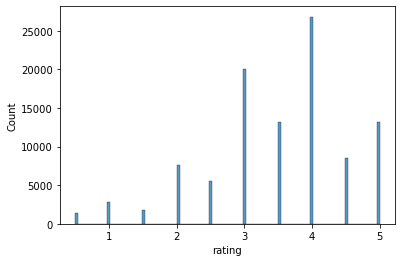

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(x=ratings_df['rating'], data = ratings_df) #jobbra ferde

Title and genres should be separated in movie.info

# Data preparation

In [8]:
movie_info['genre_list'] = movie_info['genres'].str.split('|')

In [10]:
movie_info['year'] = movie_info['title'].apply(lambda x: x.split('(')[-1].replace(')', ''))

In [11]:
print(f"'{'year'}':\n", movie_info['year'].value_counts())

'year':
 2002                311
2006                295
2001                294
2000                283
2007                282
                   ... 
Ready Player One      1
1902                  1
Babylon 5             1
1921                  1
1903                  1
Name: year, Length: 128, dtype: int64


In [12]:
movie_info.loc[movie_info['year'].apply(lambda x: x.isdigit())==False, 'year'] = np.nan 
movie_info['year'] = movie_info['year'].astype(float)

In [13]:
movie_info.head()

,movieId,title,genres,genre_list,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],1995.0


In [14]:
#movie_info['genre_list']
genre=pd.get_dummies(movie_info['genre_list'].apply(pd.Series).stack()).sum(level=0)
genre

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
movie_info=movie_info.join(genre)

In [16]:
movie_info = movie_info.drop(columns=['genres','genre_list'])

In [17]:
movie_info

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),2017.0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),2017.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),2017.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),2018.0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
join_movie=pd.merge(ratings_df,movie_info,how='left')
join_movie

,userId,movieId,rating,timestamp,title,year,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),1995.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),1995.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,964982224,Heat (1995),1995.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),1995.0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",1995.0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),2017.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),2017.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,1494273047,Get Out (2017),2017.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,1493846352,Logan (2017),2017.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [27]:
data = join_movie.drop(columns=['title','timestamp','movieId'])
X = data[data.columns.difference(['rating'])].dropna().values
y = data.dropna()['rating']

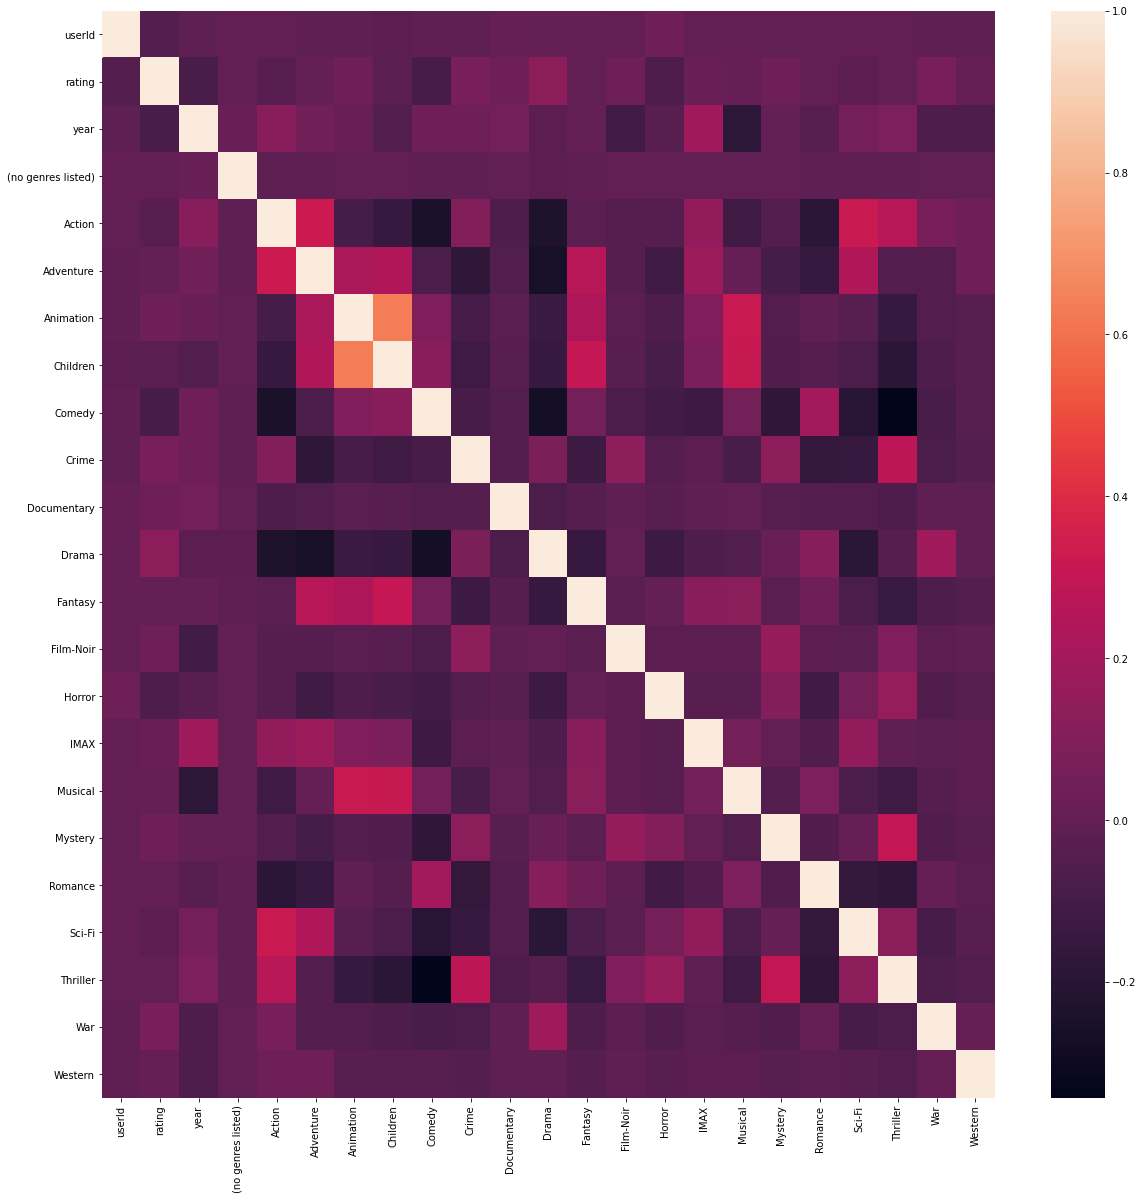

In [28]:
import seaborn as sns
%matplotlib inline

corr = data.corr()

plt.figure(figsize = (20,20))

# plot the heatmap
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
#gyerek és animáció között pozitív korrel

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
scores = cross_val_score(linreg, X, y, scoring='neg_mean_squared_error', cv=5)


In [30]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [31]:
-scores

array([1.0358968 , 0.97941802, 1.06261285, 1.01169742, 1.0899081 ])

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=1.0))
print(-cross_val_score(lasso_pipe, X, y, scoring='neg_mean_squared_error', cv=5))

NameError: name 'StandardScaler' is not defined

# Other

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

for i in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=i))
    ridge_pipe.fit(X_train, y_train) 
    print('Alpha is ', i)
    print('Train: ', ridge_pipe.score(X_train, y_train))
    print('Test: ', ridge_pipe.score(X_test, y_test))
    print('--------------')

Alpha is  1e-05
Train:  0.04896243822026891
Test:  0.04921622699794315
--------------
Alpha is  0.0001
Train:  0.04896243822026891
Test:  0.04921622699766126
--------------
Alpha is  0.001
Train:  0.04896243822026891
Test:  0.04921622699484429
--------------
Alpha is  0.01
Train:  0.048962438220267135
Test:  0.04921622696667105
--------------
Alpha is  0.1
Train:  0.048962438220098825
Test:  0.04921622668478953
--------------
Alpha is  1
Train:  0.04896243820329915
Test:  0.04921622385082347
--------------
Alpha is  10
Train:  0.04896243652418464
Test:  0.04921619399715371
--------------
Alpha is  100
Train:  0.04896226947877258
Test:  0.04921574492657732
--------------


In [76]:
from sklearn.linear_model import ElasticNet

for a in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
    elnet = ElasticNet(alpha=a, l1_ratio=0.5)
    elnet.fit(X_train, y_train)
    print(a,'Test: ', elnet.score(X_test, y_test))

1e-05 Test:  0.04921651203527133
0.0001 Test:  0.049217922828001415
0.001 Test:  0.049110144482429896
0.01 Test:  0.04204882826824341
0.1 Test:  0.014909571294822399
1 Test:  0.008775601149540346
10 Test:  0.0017563412547999535


In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import cohen_kappa_score

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)
#overfits on train

(0.8217550662232208, 0.14490118985537948)

# Data preparation for NMF

In [33]:
#NMF
from sklearn.decomposition import NMF


In [34]:
Xdf = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating').fillna(0)
Xdf

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Non-Negative Matrix Factorization (NMF)

In [35]:
%%time
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(Xdf)

Wall time: 1.12 s


In [36]:
W.shape

(610, 2)

In [37]:
H = model.components_
H.shape

(2, 9724)

In [38]:
pred = np.matmul(W,H)
pred_df = pd.DataFrame(pred)
pred_df = pred_df.set_index(Xdf.index, drop=True)
pred_df.columns = Xdf.columns
pred_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.453713,1.116739,0.881122,0.067465,0.507138,1.630670,0.725551,0.122172,0.129059,1.676402,...,0.000364,0.000312,0.000416,0.000416,0.000364,0.000416,0.000364,0.000364,0.000364,0.001181
2,0.223878,0.158004,0.000000,0.000000,0.019402,0.090817,0.000000,0.006155,0.000000,0.085681,...,0.001104,0.000946,0.001261,0.001261,0.001104,0.001261,0.001104,0.001104,0.001104,0.003581
3,0.065593,0.029343,0.024285,0.001859,0.013801,0.044118,0.019997,0.003311,0.003557,0.045425,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.568971,0.701875,0.580891,0.044477,0.330119,1.055297,0.478329,0.079206,0.085084,1.086562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.572483,0.256099,0.211954,0.016229,0.120453,0.385055,0.174532,0.028900,0.031045,0.396463,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,4.574269,2.261022,1.385903,0.106115,0.859623,2.854841,1.141208,0.211815,0.202995,2.910373,...,0.004097,0.003512,0.004682,0.004682,0.004097,0.004682,0.004097,0.004097,0.004097,0.013292
607,1.767135,0.790523,0.654259,0.050095,0.371814,1.188583,0.538743,0.089209,0.095830,1.223798,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
608,4.339618,2.332364,1.046415,0.080121,0.725824,2.514874,0.861661,0.184283,0.153270,2.536482,...,0.007461,0.006395,0.008527,0.008527,0.007461,0.008527,0.007461,0.007461,0.007461,0.024205


In [39]:
def error_NMF(Xdf,model):
    W = model.fit_transform(Xdf)
    H = model.components_
    pred = np.matmul(W,H)
    pred_df = pd.DataFrame(pred)
    pred_df = pred_df.set_index(Xdf.index, drop=True)
    pred_df.columns = Xdf.columns
    errors = pred_df - Xdf
    error_matrix = np.array(errors)
    squared_errors = (error_matrix**2)
    return squared_errors.sum()/(errors.shape[0]*errors.shape[1])

In [41]:
error_NMF(Xdf,model)

0.17023410899770375

In [42]:
%%time
model = NMF(n_components=2, init='nndsvda', random_state=0)
W = model.fit_transform(Xdf)
H = model.components_
error_NMF(Xdf,model)

Wall time: 2.75 s


0.17023410860999108

In [132]:
%%time
model = NMF(n_components=2,l1_ratio=0.2, random_state=0)
error_NMF(Xdf,model)

Wall time: 1.45 s


0.1702341084514773

In [134]:
for i in [0, 0.01, 0.1,0.2,0.4,0.6,0.8]:
    model = NMF(n_components=2,l1_ratio=i, random_state=0, solver='cd') 
    mse=error_NMF(Xdf,model)
    print('L1 ratio is ', i)
    print(mse)
    print('--------------')

Alpha is  0
0.1702341084514773
--------------
Alpha is  0.01
0.1702341084514773
--------------
Alpha is  0.1
0.1702341084514773
--------------
Alpha is  0.2
0.1702341084514773
--------------
Alpha is  0.4
0.1702341084514773
--------------
Alpha is  0.6
0.1702341084514773
--------------
Alpha is  0.8
0.1702341084514773
--------------


In [135]:
for i in [10,100,200,500]:
    model = NMF(n_components=2,max_iter=i, random_state=0, solver='cd') 
    mse=error_NMF(Xdf,model)
    print('Max.iteration is ', i)
    print(mse)
    print('--------------')

C:\Users\kbogi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Max.iteration is  10
0.17036223429699826
--------------
Max.iteration is  100
0.1702341084514773
--------------
Max.iteration is  200
0.1702341084514773
--------------
Max.iteration is  500
0.1702341084514773
--------------


In [11]:
for i in [2,3,10,100]:
    model = NMF(n_components=i,max_iter=100, random_state=0, solver='cd') 
    mse=error_NMF(Xdf,model)
    print('components: ', i)
    print(mse)
    print('--------------')

components:  2
0.1702341084514773
--------------
components:  3
0.1645632287294963
--------------


C:\Users\kbogi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


components:  10
0.14481150222969616
--------------


C:\Users\kbogi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


components:  100
0.07218570539574508
--------------


In [58]:
%%time
model = NMF(n_components=10,max_iter=500, random_state=0)
error_NMF(Xdf,model)

Wall time: 3.29 s


0.14481149574771007

# NMF CV

In [65]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [54]:
#pip install surprise
#used "conda install -c conda-forge scikit-surprise" in anaconda instead

In [61]:
from surprise import SVD
from surprise import NMF
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise.reader import Reader
#https://www.jiristodulka.com/post/recsys_cf/

In [77]:
data = Dataset.load_from_df(join_movie[["userId","movieId","rating"]], reader=reader)

In [79]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['mse'], cv=5)
gs.fit(data)

In [81]:
print(gs.best_score['mse'])

0.8500877472439837


# With surprise dataset:

In [82]:
%%time
min_movie_ratings = 2 # movie was rated at least 
min_user_ratings =  1 # user rated movies at least


ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['mse'], cv=5)
gs.fit(data)
print(gs.best_score['mse'])

0.8282801768039683
Wall time: 4min 54s


In [53]:
#def rmse_cv(model):
 #   rmse= np.sqrt(-cross_val_score(model, Xdf,y_true=Xdf, scoring="neg_mean_squared_error", cv = 5))
  #  return(rmse)

In [55]:
#rmse_cv(model)

In [66]:
from sklearn.metrics import mean_squared_error
#params = [{'max_iter': [10,50,100]}]

#model = NMF(n_components=100, random_state=0, solver='cd')
#y_true=Xdf 

# cv='None'  ~ deafult: to use the default 5-fold cross validation
#gridsearch = GridSearchCV(model,param_grid=params, scoring = mse)
#gridsearch.fit(Xdf)

In [27]:
#https://github.com/kimjingu/nonnegfac-python/blob/master/nonnegfac/nnls.py
      

In [26]:
#cv_pca(Xdf,xx,p_holdout=0.2)

In [16]:
np.linalg.matrix_rank(Xdf)

610